<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/PredictionComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

Execute the following cell in case of a dRNN model or in case of a Preisach RNN model:




In [24]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = True

# The scaler is used to rescale the dataset values between -1 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# The normalizer is used to normalize the dataset
normalizer = preprocessing.StandardScaler()

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset 
    temp_data_norm = pd.DataFrame(scaler.fit_transform(temp_data[['H', 'B']]), columns=['H', 'B']) 
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

Execute the following cell in case of a HRNN model:


In [37]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = True

# The scaler is used to normalize the H dataset values
H_scaler = preprocessing.StandardScaler()

# The scaler is used to rescale the B dataset values between -1 and 1
B_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset
    temp_data_norm = pd.DataFrame(H_scaler.fit_transform(temp_data[['H']]), columns=['H']) 
    temp_data_norm['B'] = B_scaler.fit_transform(temp_data[['B']])
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

In [38]:
seq_len = 20
subsample = False
subsample_len = 200 

train_dataset = collections.OrderedDict()

if subsample:
    for freq in dataset:
        if freq != 'P2_20Hz.CSV':
            train_dataset[freq] = dataset[freq].iloc[np.arange(0, len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
else:
    for freq in dataset:
        if freq != 'P2_20Hz.CSV':
            train_dataset[freq] = dataset[freq]

val_dataset = collections.OrderedDict()

if subsample:
    for freq in dataset:
        if freq != 'P2_1kHz.CSV':
            if freq != 'P2_20Hz.CSV': 
                val_dataset[freq] = dataset[freq].iloc[np.arange(int((len(dataset[freq])/subsample_len) / 2), len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
            else:
                val_dataset[freq] = dataset[freq].iloc[np.arange(0, len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
else:
    for freq in dataset:
        if freq == 'P2_20Hz.CSV':
            val_dataset[freq] = dataset[freq]

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.offsetbox import AnchoredText

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    anchored_text = AnchoredText('MSE:' + str(round(MSE, 6)) + '\n' + 'MAE:' + str(round(MAE, 6)), loc=2)
    ax1.add_artist(anchored_text)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

# Training Procedure:
The **Training** has been performed over the Dataset including the first magnetization curve and with the exclusion of the median frequency (input at 20 Hz). 

The **Test Set** contains the 20 Hz hysteretic curve

The training batches have been assembled grouping together the 10 different frequencies curves, divided in sequences. The **sequence length** is fixed to **20**:
```
Batch 0 = [sample_0.5Hz_from_t0_to_t20, sample_1Hz_from_t0_to_t20, ..., sample_1kHz_from_t0_to_t20]

Batch 1 = [sample_0.5Hz_from_t20_to_t40, sample_1Hz_from_t20_to_t40, ..., sample_1kHz_from_t20_to_t40]

Batch 2 = ...
```
The total number of batches is determined by the number of samples describing the lowest frequency curve (0.5 Hz), which is composed by 400000 samples. This amount of samples describes two periods of the hysteretic curve where the first period represents the first magnetization curve. 

The resulting number of batches is 20000. 

To fill the batches even with the shorter curves, their second period is repeated. 

# dRNN Model:

## dRNN with **256** units with **linear** output layer:
 
*  Stateful Training.
*  The **Validation Set** contains the 20 Hz curve.
*  10 epochs, 20000 batches.

In [27]:
# Read training prediction file    
with open('/content/dRNN_256_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_1_epochs_10.h5training_predictions.txt', 'r') as file:
     model_predictions_training = json.load(file)

In [28]:
# Read test prediction file    
with open('/content/dRNN_256_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_1_epochs_10.h5test_predictions.txt', 'r') as file:
     model_predictions_test = json.load(file)

### Training Set Predictions

Plotting the predictions over the signals provided as training:

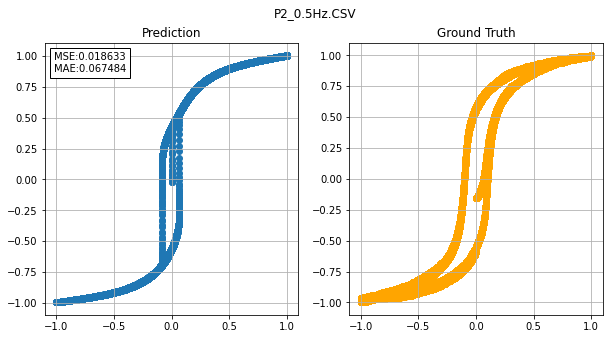

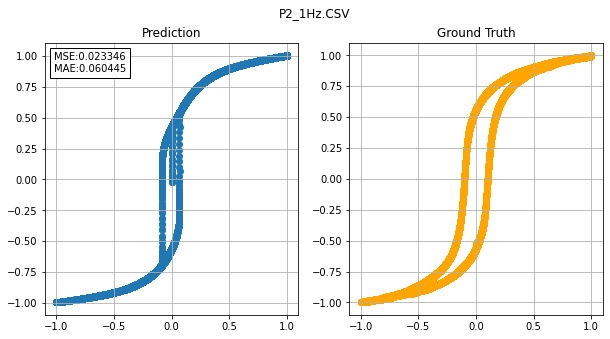

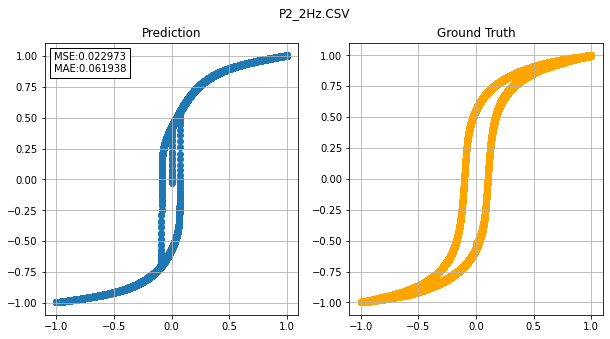

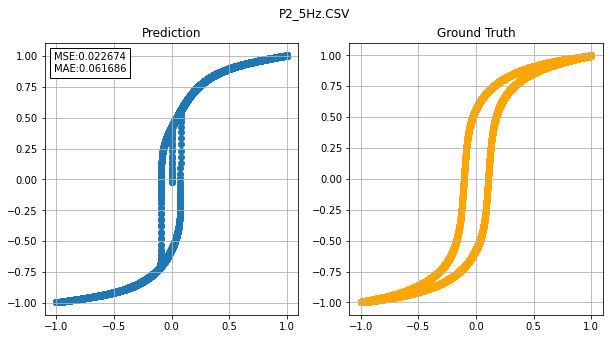

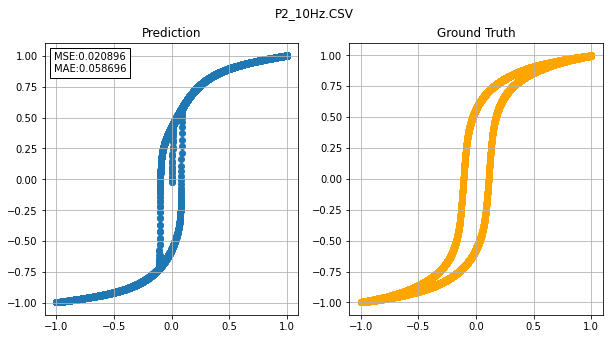

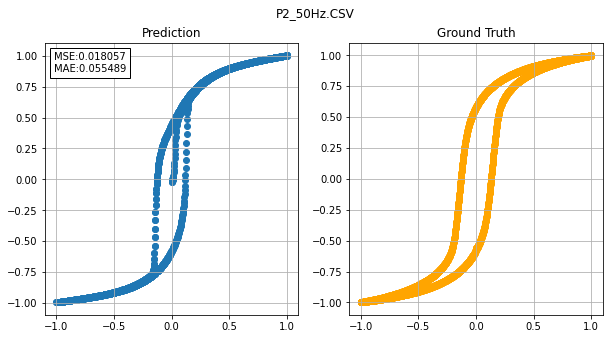

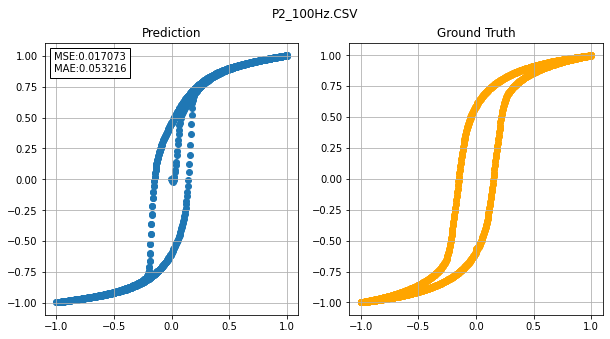

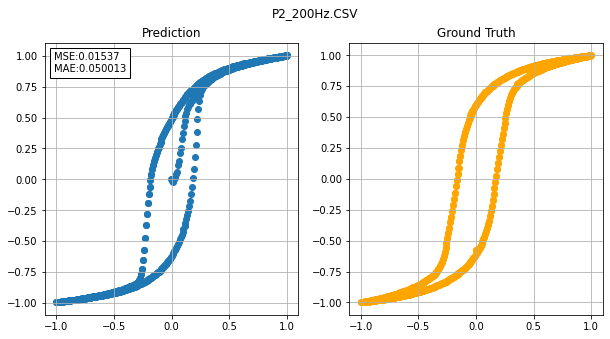

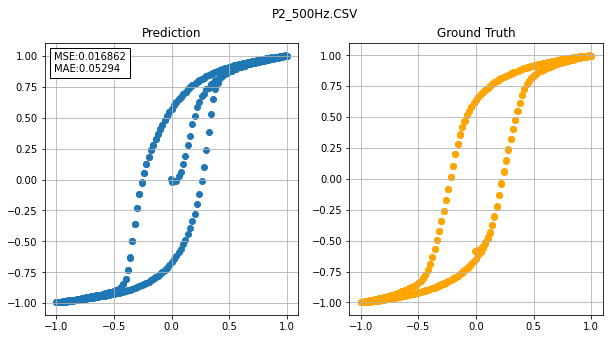

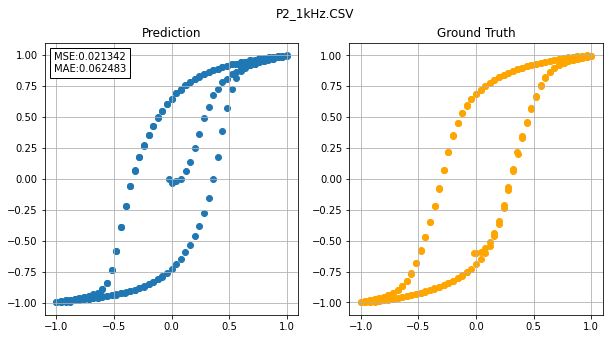

In [29]:
# Testing the model on the validation data, excluded the 20 Hz signal
y_pred = []

for freq in train_dataset:
    x_signal = np.array(train_dataset[freq][['H']])
    
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)

    # Reshape batch predictions into a single array
    y_pred = np.array(model_predictions_training[freq]).reshape(-1, 1)
    y_true = train_dataset[freq]['B']
    
    plot_prediction(y_pred, y_true, x_signal, freq)

### Test Set Predictions

Plotting the predictions over the test set composed by the 20 Hz hysteretic curve:

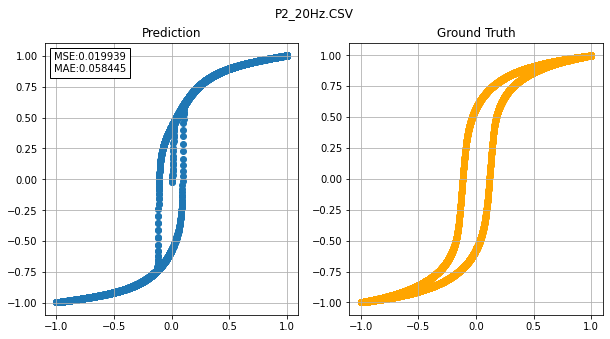

In [30]:
# Testing the model on the 20 Hz signal in the Validation Data
y_pred = []

freq = 'P2_20Hz.CSV'
        
x_signal = np.array(val_dataset[freq][['H']])
    
# Divide the signal in batches
x = x_signal.reshape(-1, seq_len)

# Reshape batch predictions into a single array
y_pred = np.array(model_predictions_test[freq]).reshape(-1, 1)
y_true = val_dataset[freq]['B']
    
plot_prediction(y_pred, y_true, x_signal, freq)

# HRNN Model:

## HRNN with **404** units:

*  Stateful Training.
*  The **Validation Set** contains the 20 Hz curve. 
*  10 epochs, 20000 batches.

404 neurons were initialized with forward transition values α ranging from
0 to 1 at 0.01 intervals (resulting in 101 discrete forward
transition values). Each forward transition value had four
different reverse transition values (β values) associated with it,
with differences ranging from 0.02 to 0.47.

In [35]:
# Read training prediction file    
with open('/content/HRNN_404_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_1_epochs_10.h5training_predictions.txt', 'r') as file:
     model_predictions_training = json.load(file)

In [36]:
# Read test prediction file    
with open('/content/HRNN_404_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_1_epochs_10.h5test_predictions.txt', 'r') as file:
     model_predictions_test = json.load(file)

### Training Set Predictions

Plotting the predictions over the signals provided as training:

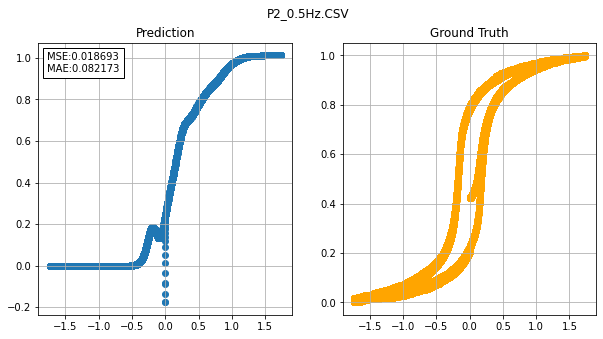

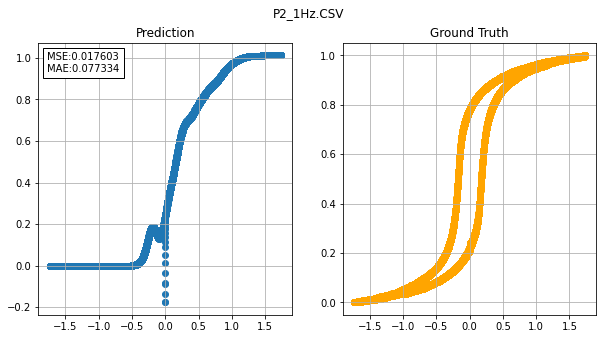

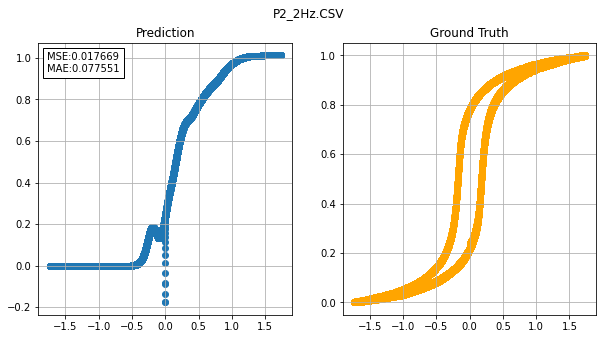

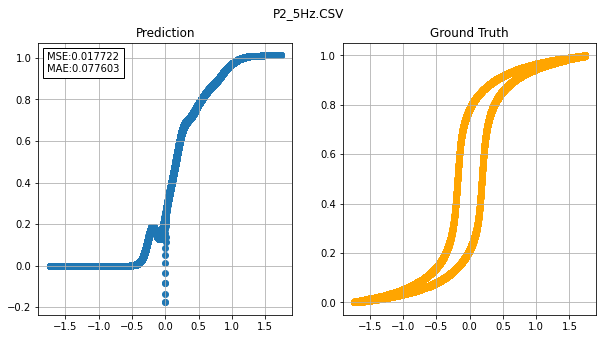

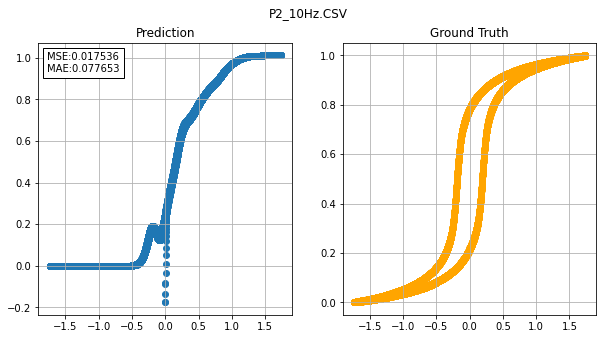

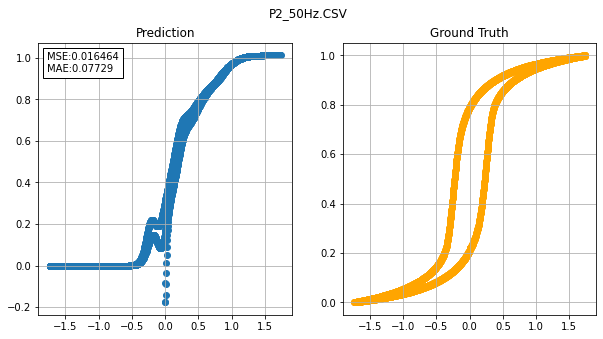

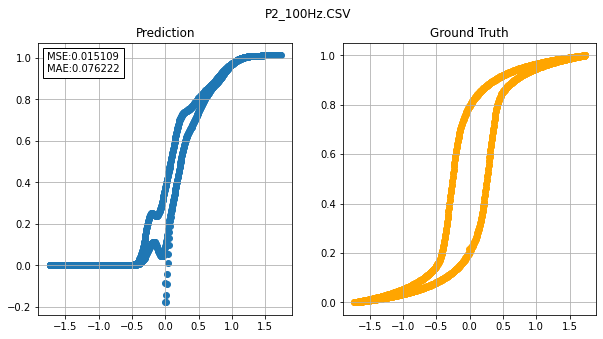

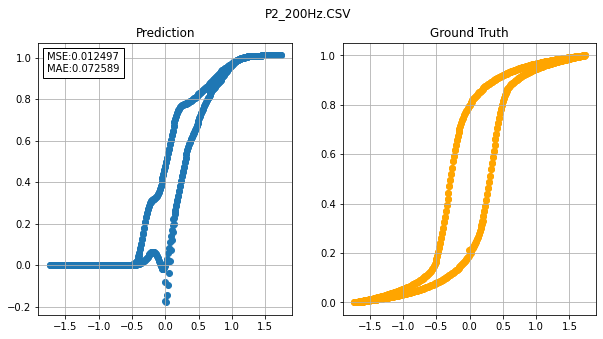

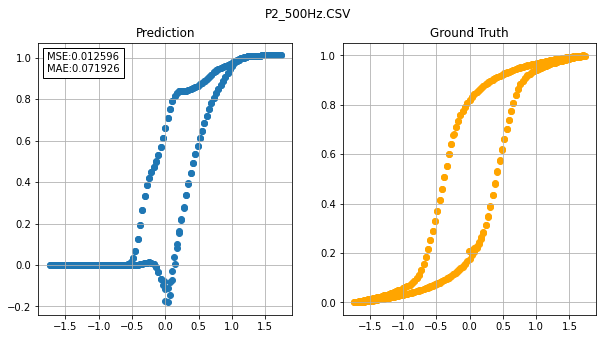

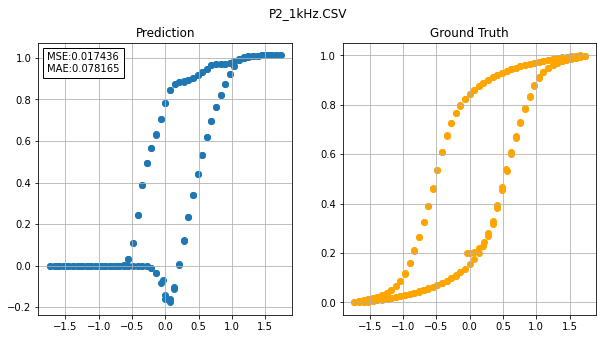

In [39]:
# Testing the model on the validation data, excluded the 20 Hz signal
y_pred = []

for freq in train_dataset:
    x_signal = np.array(train_dataset[freq][['H']])
    
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)

    # Reshape batch predictions into a single array
    y_pred = np.array(model_predictions_training[freq]).reshape(-1, 1)
    y_true = train_dataset[freq]['B']
    
    plot_prediction(y_pred, y_true, x_signal, freq)

### Test Set Predictions

Plotting the predictions over the test set composed by the 20 Hz hysteretic curve:

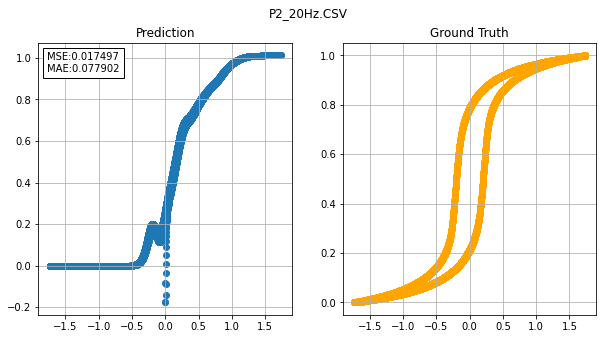

In [40]:
# Testing the model on the 20 Hz signal in the Validation Data
y_pred = []

freq = 'P2_20Hz.CSV'
        
x_signal = np.array(val_dataset[freq][['H']])
    
# Divide the signal in batches
x = x_signal.reshape(-1, seq_len)

# Reshape batch predictions into a single array
y_pred = np.array(model_predictions_test[freq]).reshape(-1, 1)
y_true = val_dataset[freq]['B']
    
plot_prediction(y_pred, y_true, x_signal, freq)

# Preisach RNN Model:

## Preisach RNN with **6 Play Operators** in the Input Layer and **12 units** in the hidden layer:

*  Stateful Training.
*  The **Validation Set** contains the 20 Hz curve. 
*  10 epochs, 20000 batches.

The Play Operators represent a system memory and are defined by the following equations:

$P_j(t) = \max(u(t) - r_j, \min(u(t) + r_j, P_j(t - 1)))$

$P_j(0) = \max(u(0) - r_j, \min(u(0) + r_j, k_0))$

$r_j = (j - 1)/n \cdot (\max(u(t)) - \min(u(t)))$

$j = 1, ..., n$

In [31]:
# Read training prediction file    
with open('/content/PreisachRNN_12_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_1_epochs_10.h5training_predictions.txt', 'r') as file:
     model_predictions_training = json.load(file)

In [32]:
# Read test prediction file    
with open('/content/PreisachRNN_12_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_1_epochs_10.h5test_predictions.txt', 'r') as file:
     model_predictions_test = json.load(file)

### Training Set Predictions

Plotting the predictions over the signals provided as training:

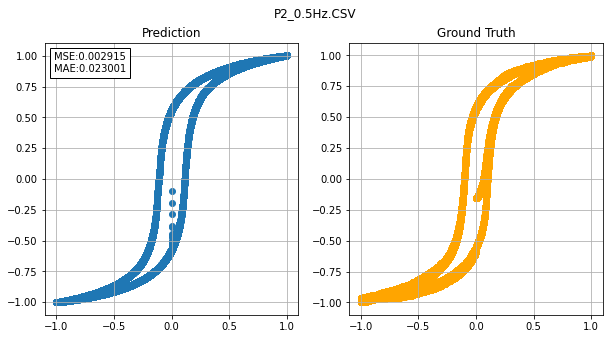

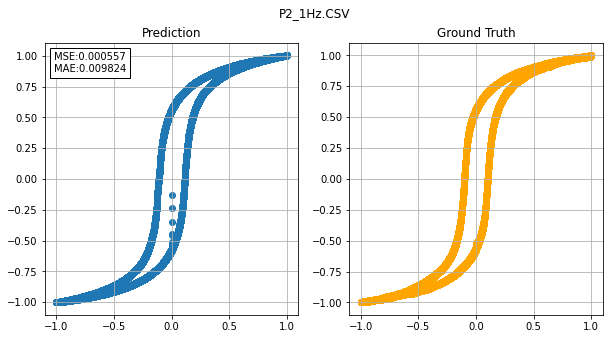

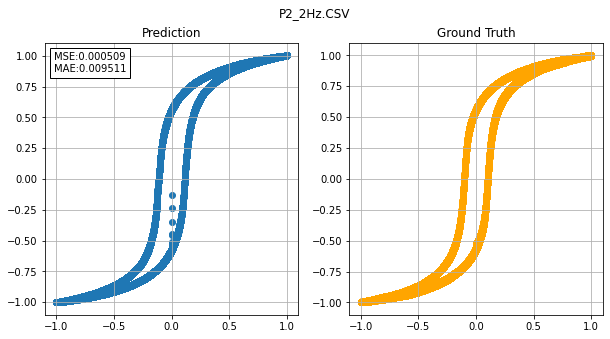

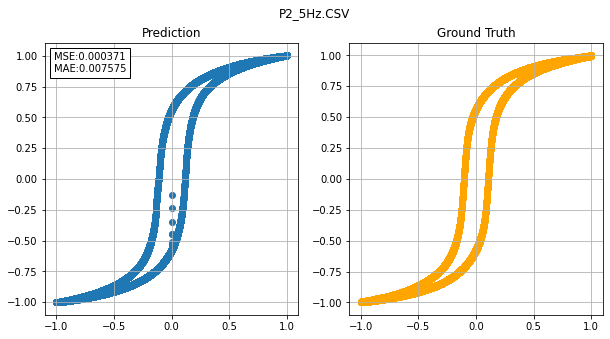

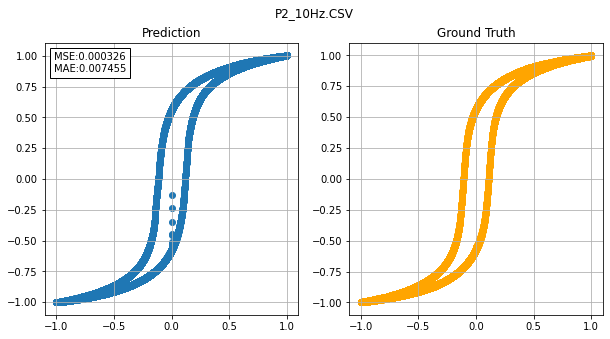

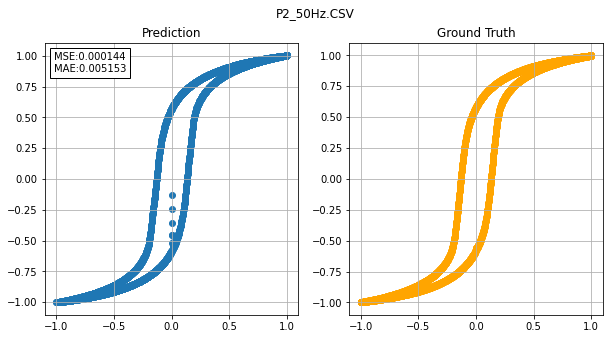

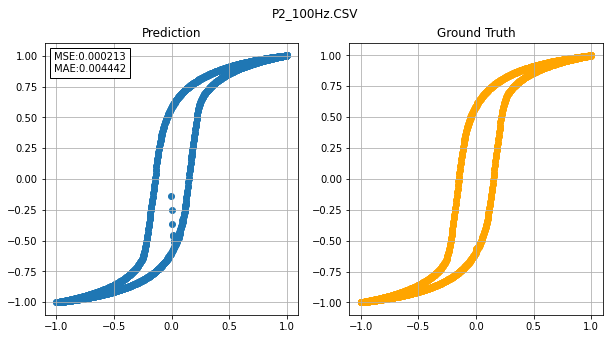

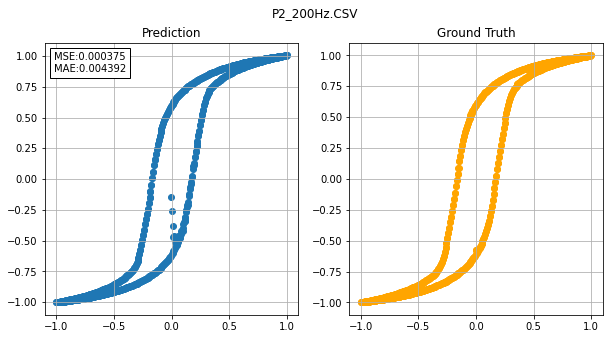

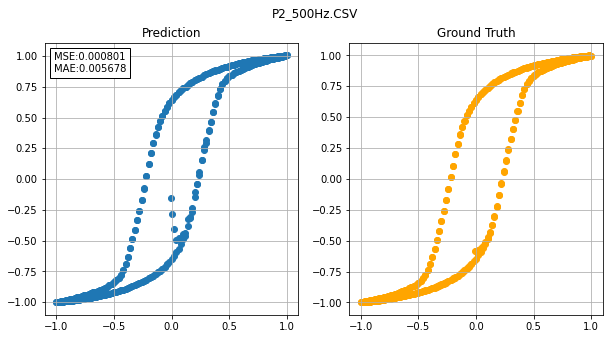

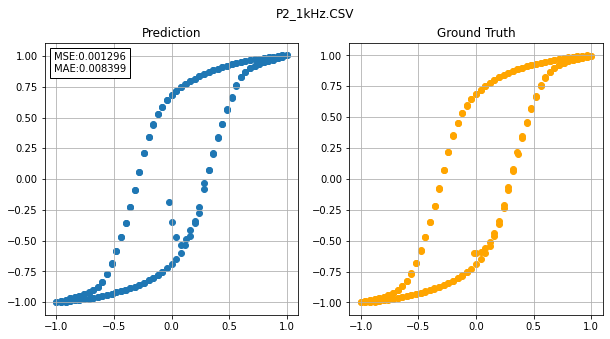

In [33]:
# Testing the model on the validation data, excluded the 20 Hz signal
y_pred = []

for freq in train_dataset:
    x_signal = np.array(train_dataset[freq][['H']])
    
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)

    # Reshape batch predictions into a single array
    y_pred = np.array(model_predictions_training[freq]).reshape(-1, 1)
    y_true = train_dataset[freq]['B']
    
    plot_prediction(y_pred, y_true, x_signal, freq)

### Test Set Predictions

Plotting the predictions over the test set composed by the 20 Hz hysteretic curve:

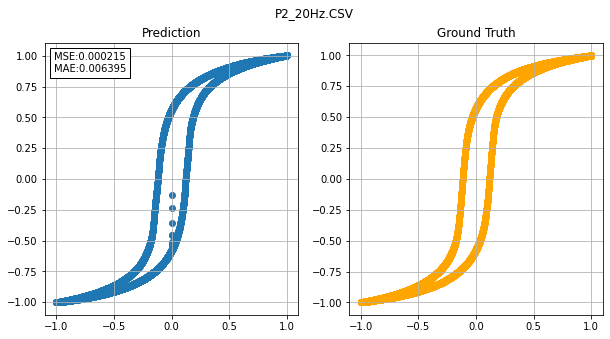

In [34]:
# Testing the model on the 20 Hz signal in the Validation Data
y_pred = []

freq = 'P2_20Hz.CSV'
        
x_signal = np.array(val_dataset[freq][['H']])
    
# Divide the signal in batches
x = x_signal.reshape(-1, seq_len)

# Reshape batch predictions into a single array
y_pred = np.array(model_predictions_test[freq]).reshape(-1, 1)
y_true = val_dataset[freq]['B']
    
plot_prediction(y_pred, y_true, x_signal, freq)